# KNN Implementation

In [94]:
import numpy as np
import matplotlib.pyplot as plt

## Data Pre-Processing

### Get data

In [95]:
data=np.array( [
    [150, 7.0, 1, 'Apple'],
    [120, 6.5, 0, 'Banana'],
    [180, 7.5, 2, 'Orange'],
    [155, 7.2, 1, 'Apple'],
    [110, 6.0, 0, 'Banana'],
    [190, 7.8, 2, 'Orange'],
    [145, 7.1, 1, 'Apple'],
    [115, 6.3, 0, 'Banana']
]
)

### Encode data

In [96]:
# get unique class labels
classes = np.unique(data[:,-1])

# Assign a numerical value to each class label
for i in range(data.shape[0]):
    data[i][3] = np.where(classes==data[i][3])[0][0]

### Split data

In [97]:
# Split features and labels
X_train = np.array(data[:, :-1], dtype=float)
y_train = np.array(data[:, -1], dtype=int)

### Normalization methods

In [98]:
def minMaxNormalization(X_train):
    for col in range(X_train.shape[1]):
        min_val = np.min(X_train[:, col])
        max_val = np.max(X_train[:, col])
        X_train[:, col] = (X_train[:, col] - min_val) / (max_val - min_val)
    return X_train

def zScoreNormalization(X_train):
    for col in range(X_train.shape[1]):
        mn = np.mean(X_train[:, col])
        std = np.std(X_train[:, col])
        X_train[:, col] = (X_train[:, col] - mn) / std
    return X_train

# Applying Z-score normalization on the training data
X_train = zScoreNormalization(X_train)

## Different Distance Functions

In [99]:
def eucDist(a,b):
    return np.sqrt(np.sum((a-b)**2))

In [100]:
def manhattanDist(a,b):
    return np.sum(np.abs(a-b))

In [101]:
def minkowskiDist(a,b,p=2):
    return (np.sum(np.abs(a-b)**p))**(1/p)

## KNN and Weighted KNN Implementation

In [102]:
class KNN():
    def __init__(self, k=3):
        self.k=k  # number of neighbors to consider

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict_one(self, x, distFunction):
        distances = [distFunction(x,j) for j in self.X_train]  # calc distance from test point to every train point
        kNearestIndices = np.argsort(distances)[:self.k]       # indices of the k smallest distances
        arrOfkLabels = np.array([self.y_train[l] for l in kNearestIndices])  # get the labels of those k points
        freq = np.zeros(len(classes)) # to count how many neighbors belong to each class
        for k in arrOfkLabels:
           freq[k] += 1
        return np.argmax(freq)  # return the class with the most votes

    def predict(self, X_test, distFunction):
        # predict the label for each test point
        y_pred = [self.predict_one(X_test[i], distFunction) for i in range(len(X_test))]
        return np.array(y_pred)

In [103]:
class weightedKNN(KNN):
    def predict_one(self, x, distFunction):
        distances = [distFunction(x,j) for j in self.X_train]  # same as before, calculate all distances
        kNearestIndices = np.argsort(distances)[:self.k]       # indices of k nearest neighbors
        kNearestDistances = np.array([distances[l] for l in kNearestIndices])
        arrOfkLabels = np.array([self.y_train[l] for l in kNearestIndices])
        totalWeight = np.zeros(len(classes))  # weight accumulators for each class
        for k in range(len(arrOfkLabels)):
            totalWeight[arrOfkLabels[k]] += 1/(kNearestDistances[k])  # smaller distance -> higher weight
        return np.argmax(totalWeight)  # return class with highest total weight

## Making Predictions

In [104]:
# Initialize model and train on data
knn = weightedKNN()
knn.fit(X_train, y_train)

In [105]:
test_data = np.array([
    [118, 6.2, 0],  # Expected: Banana
    [160, 7.3, 1],  # Expected: Apple
    [185, 7.7, 2]   # Expected: Orange
])

# normalize test data same way we did for training
# ideally, should use same mean/std from training set in real scenarios but for simplicity, just applying z-score again here

test_data = zScoreNormalization(test_data)

In [106]:
preds = knn.predict(test_data, eucDist)
predLabels = np.array([classes[i] for i in preds]) # convert numeric labels back to fruit names

print(predLabels)

['Banana' 'Apple' 'Orange']


## Accuracy Checker

In [107]:
trueLabels = ['Banana', 'Apple', 'Orange']

def accuracyChecker(trueLabels, predLabels):
    count = 0
    for i in range(len(trueLabels)):
        if trueLabels[i] == predLabels[i]:
            count += 1
    return count/len(trueLabels) # returns accuracy as fraction of correct predictions

print(accuracyChecker(trueLabels, predLabels))

1.0


## Decision Boundary Plot
2D visualisation using any two features (demonstrated with weight and size here)

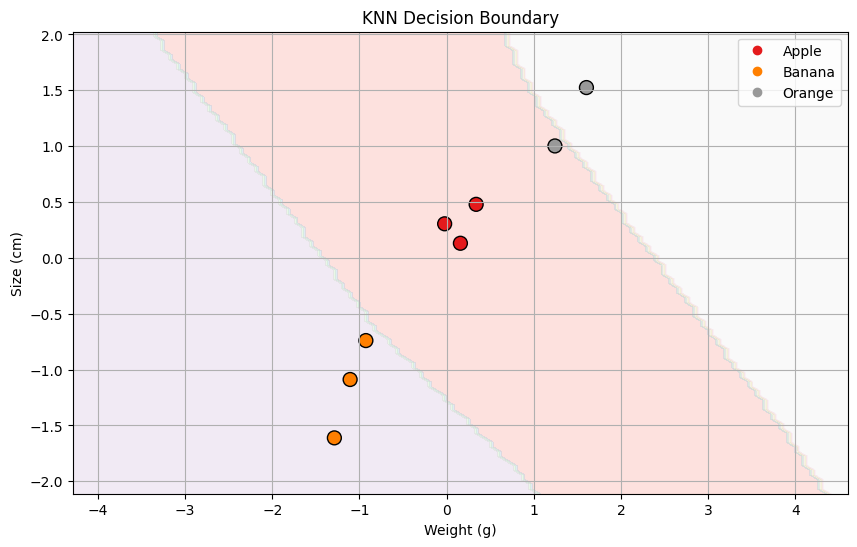

In [108]:
def plot_decision_boundary(knn, X, y, fixed_color=0, resolution=100):
    # setting range for the grid
    x_min, x_max = X[:, 0].min() - 3, X[:, 0].max() + 3
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # generate a mesh grid of points across the feature space
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))

    grid_points = np.c_[xx.ravel(), yy.ravel()]  # flatten grid into coordinate pairs
    grid_points = np.insert(grid_points, 2, fixed_color, axis=1)  # insert fixed color feature

    # predict class of each point in the grid
    Z = knn.predict(grid_points, eucDist)
    Z = Z.reshape(xx.shape)  # reshape back to 2D

    # plot the regions and training points
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='Pastel1')

    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1', edgecolor='k', s=100)
    plt.xlabel("Weight (g)")
    plt.ylabel("Size (cm)")
    plt.title("KNN Decision Boundary")
    plt.legend(handles=scatter.legend_elements()[0], labels=['Apple', 'Banana', 'Orange'])
    plt.grid(True)
    plt.show()

# visualize decision boundary with color index = 0 (basically assuming we're comparing Banana region)
plot_decision_boundary(knn, X_train, y_train, fixed_color=0)